<h3><center>Task -2 </center><h3>

In [79]:
# Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import mediapipe as mp
import cv2
import os

In [80]:
# Initializing the path to the input video

input_path = "../Sample_Videos/sample6.mp4"
video = cv2.VideoCapture(input_path)
video_name = os.path.split(input_path)[1]

This function takes the input path as argument and outputs 4 centroid values as dictionary

In [81]:
# Function to get the centroid of the object
def find_centroid(input_path):
    cap = cv2.VideoCapture(input_path)
    centroid = {}

    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()

    # Initializing the variables
    right_centroid_x = []
    right_centroid_y = []
    left_centroid_x = []
    left_centroid_y = []

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results_pose = pose.process(frame)

            right_centroid_x_frames = []
            right_centroid_y_frames = []
            left_centroid_x_frames = []
            left_centroid_y_frames = []
                
            # Pose values
            right = [16, 18, 20, 22]
            left = [15, 17, 19, 21]

            # Getting the centroid of the right hand
            for i in (right):
                right_centroid_x_frames.append(round(results_pose.pose_landmarks.landmark[i].x * frame.shape[1], 2))
                right_centroid_y_frames.append(round(results_pose.pose_landmarks.landmark[i].y * frame.shape[0], 2))

            # Getting the centroid of the left hand
            for i in (left):
                left_centroid_x_frames.append(round(results_pose.pose_landmarks.landmark[i].x * frame.shape[1], 2))
                left_centroid_y_frames.append(round(results_pose.pose_landmarks.landmark[i].y * frame.shape[0], 2))

            # Appending the centroid to the list
            right_centroid_x.append(round(np.mean(right_centroid_x_frames), 2))
            right_centroid_y.append(round(np.mean(right_centroid_y_frames), 2))
            left_centroid_x.append(round(np.mean(left_centroid_x_frames), 2))
            left_centroid_y.append(round(np.mean(left_centroid_y_frames), 2))
        
        else:
            break

    cap.release()
    centroid["right_centroid_x"] = right_centroid_x
    centroid["right_centroid_y"] = right_centroid_y
    centroid["left_centroid_x"] = left_centroid_x
    centroid["left_centroid_y"] = left_centroid_y

    return centroid

In [82]:
# Taking all values into dictionary
centroid = find_centroid(input_path)

In [83]:
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [84]:
# Function to get the hand distance
hand_distance = []
no_of_frames = len(centroid["right_centroid_x"])

for i in range(no_of_frames-1):
    right_dist = euclidean_distance(centroid["right_centroid_x"][i], centroid["right_centroid_x"][i+1], centroid["right_centroid_y"][i], centroid["right_centroid_y"][i+1])
    left_dist = euclidean_distance(centroid["left_centroid_x"][i], centroid["left_centroid_x"][i+1], centroid["left_centroid_y"][i], centroid["left_centroid_y"][i+1])
    hand_distance.append(max(right_dist, left_dist))

# print(hand_distance)

In [85]:
# Function to get the hand height
hand_height = []

for i in range(no_of_frames):
    hand_height.append(min(centroid["right_centroid_y"][i],centroid["left_centroid_y"][i]))

# print(hand_height)

To take the threashold, I calculated the value as Threashold = Mean - Standard Deviation

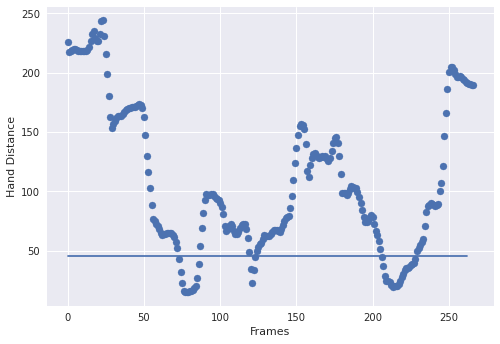

In [86]:
# Finding threashold for the hand distance
with plt.style.context('seaborn'):
    plt.scatter([i for i in range(no_of_frames-1)], hand_distance)
    mean_hand_distance = np.mean(hand_distance) - np.std(hand_distance)
    # Threshold = Mean - Standard Deviation
    plt.plot([0, 262], [mean_hand_distance, mean_hand_distance])

plt.ylabel("Hand Distance")
plt.xlabel("Frames")
plt.show()

To take the threashold, I calculated the value as Threashold = Mean + Standard Deviation

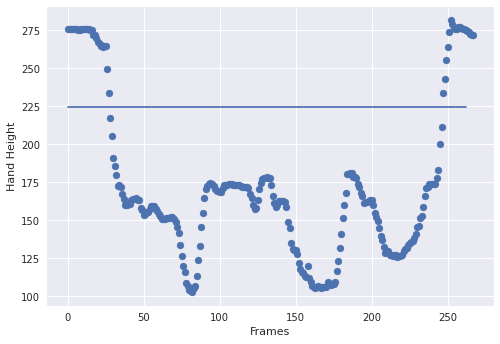

In [87]:
# Finding threashold for the hand height
with plt.style.context('seaborn'):
    plt.scatter([i for i in range(no_of_frames)], hand_height)
    mean_hand_height = np.mean(hand_height) + np.std(hand_height)
    # Threashold = Mean + Standard Deviation
    plt.plot([0, 262], [mean_hand_height, mean_hand_height])

plt.ylabel("Hand Height")
plt.xlabel("Frames")
plt.show()


Only when the hand distance is above threashold and hand height is below threashold, the frame will be accepted

In [88]:
# Process the Output Video
cap = cv2.VideoCapture(input_path)
output_name = video_name.split(".")[0] + "_output.mp4"
output_path = os.path.join("../Output/"+video_name.split(".")[0]+"/", output_name)
# print(output_path)
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

output_frames = 0
curr_frame = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        if (hand_distance[curr_frame-1] > mean_hand_distance) and (hand_height[curr_frame] < mean_hand_height):
            out.write(frame)
            output_frames += 1
        curr_frame += 1
    else:
        break
    
# print(output_frames)
cap.release()

In [89]:
# Create the Video Summary

video_summary = {}
video_summary["Filename"] = video_name
video_summary["Hand_Height"] = hand_height
video_summary["Hand_Distance"] = hand_distance
video_summary["Initial_Frame_Count"] = no_of_frames
video_summary["Post_KFS_Frame_Count"] = output_frames
video_summary["Percentage_Reduction"] = round(((no_of_frames - output_frames)/no_of_frames)*100, 2)
video_summary["Hand_Height_Threshold_Value"] = mean_hand_height
video_summary["Hand_Distance_Threshold_Value"] = mean_hand_distance

In [90]:
# Summary into the json file
output_name_json = video_name.split(".")[0] + "_output.json"
output_path_json = os.path.join("../Output/"+video_name.split(".")[0]+"/", output_name_json)

with open(output_path_json,"w") as w:
    w.write(json.dumps(video_summary))

In [91]:
# For checking if the output video is correct
print(video_summary["Initial_Frame_Count"],video_summary["Post_KFS_Frame_Count"], video_summary["Percentage_Reduction"])

268 178 33.58
